In [59]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule, ImputationDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.ops.imputation import add_missing_values
from tsl.engines import Imputer
from tsl.transforms import MaskInput
from tsl.nn.models import GRINModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
from tsl.metrics import torch as torch_metrics
import matplotlib.pyplot as plt
import torch


In [60]:
p_fault, p_noise = 0., 0.25
dataset = add_missing_values(PemsBay(),
                                p_fault=p_fault,
                                p_noise=p_noise,
                                min_seq=12,
                                max_seq=12 * 4,
                                seed=56789)
 
    
adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = ImputationDataset(target=dataset.dataframe()[-5000:],
                                    mask=dataset.training_mask[-5000:],
                                    eval_mask=dataset.eval_mask[-5000:],
                                    covariates=None,
                                    transform=MaskInput(),
                                    connectivity=adj,
                                    window=1,
                                    stride=1)


scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.1, 'test_len': 0.2}),
    batch_size=1,
    workers=8)
dm.setup(stage='test')
dm.trainset = list(range(len(torch_dataset)))

/storagenfs/p.magos/miniconda3/envs/TSGen/lib/python3.11/site-packages/tsl/datasets/pems_bay.py:84: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(df.index[0], df.index[-1], freq='5T')
/storagenfs/p.magos/miniconda3/envs/TSGen/lib/python3.11/site-packages/tsl/datasets/pems_bay.py:96: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)


In [61]:
loss_fn = torch_metrics.MaskedMAE()
loss_fn2 = torch_metrics.MaskedMRE()
loss_fn3 = torch_metrics.MaskedMSE()

# setup generator
imputer = Imputer.load_from_checkpoint('/storagenfs/p.magos/TSGen/logs/prediction/best-model-epoch=93-val_loss=0.5437.ckpt')

In [62]:
imputer.hparams

"impute_only_missing":    False
"metrics":                {'mae': MaskedMAE(), 'mse': MaskedMSE(), 'mape': MaskedMAPE()}
"model_class":            <class 'tsl.nn.models.stgn.grin_model.GRINModel'>
"model_kwargs":           {'n_nodes': 325, 'input_size': 1, 'hidden_size': 64, 'ff_size': 64, 'embedding_size': 8, 'n_layers': 1, 'kernel_size': 2, 'decoder_order': 1, 'layer_norm': False, 'dropout': 0, 'ff_dropout': 0, 'merge_mode': 'mlp'}
"optim_class":            <class 'torch.optim.adam.Adam'>
"optim_kwargs":           {'lr': 0.001, 'weight_decay': 0}
"prediction_loss_weight": 1.0
"scale_target":           True
"scheduler_class":        <class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
"scheduler_kwargs":       {'eta_min': 0.0001, 'T_max': 300}
"warm_up_steps":          0
"whiten_prob":            0.05

In [63]:
trainer = Trainer()

imputer.freeze()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [64]:
output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
output = imputer.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true, mask, eval_mask = (output['y_hat'], output['y'], output['mask'], output['eval_mask'])
y_hat = torch.tensor(y_hat)
y_true = torch.tensor(y_true)
mask = torch.tensor(mask)
eval_mask = torch.tensor(eval_mask)
res = dict(test_mae=loss_fn(y_hat, y_true, mask=mask), test_mre=loss_fn2(y_hat, y_true, mask=mask), test_mse=loss_fn3(y_hat, y_true, mask=mask))
res

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Only args ['x', 'mask', 'edge_index', 'edge_weight'] are forwarded to the model (GRINModel).


Predicting DataLoader 0: 100%|██████████| 1000/1000 [00:15<00:00, 62.62it/s]


{'test_mae': tensor(3.1754),
 'test_mre': tensor(0.0521),
 'test_mse': tensor(37.4995)}

In [77]:
input = y_true[-200:]
mask_ = mask[-200:]
mask_ = torch.cat([mask_[-200:-100], torch.zeros(mask[-100:].size(), dtype=torch.bool)])
prediction = imputer.predict(input, torch.tensor(adj[0]), torch.tensor(adj[1]), mask_)

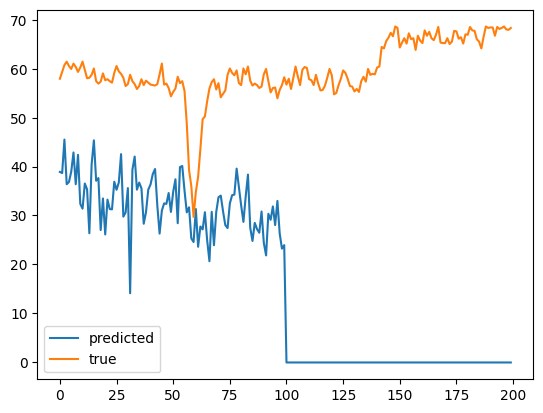

In [78]:
plt.plot(prediction[:, 0, 2], label='predicted')
plt.plot(input[:, 0, 2], label='true')
plt.legend()
plt.show()

In [79]:
prediction = prediction.reshape(prediction.shape[0], prediction.shape[-2])

In [80]:
import pandas as pd

cols = dataset.dataframe().columns.droplevel('channels')
df = pd.DataFrame(prediction, columns=cols)

In [81]:
df

nodes,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
0,0.780208,0.098372,38.911236,36.295021,44.201542,46.375034,16.755600,28.650473,38.409981,45.351341,...,43.428886,39.601494,42.656532,39.158836,42.126179,23.542740,40.999557,39.860786,42.287167,41.796078
1,0.780208,0.087062,38.685303,36.454109,40.035973,29.852533,18.968430,27.696079,38.343384,18.904331,...,32.104111,40.338299,47.064331,40.026653,43.682137,24.635624,43.751709,47.531242,45.115162,42.955105
2,0.780208,0.098372,45.534252,30.857933,45.635460,35.631264,20.460085,39.852272,30.188065,48.348198,...,25.961880,37.870148,42.004078,37.990463,29.943836,33.145985,39.526943,38.147224,40.698776,37.494125
3,0.780208,0.098372,36.393963,34.634735,42.733562,44.947353,16.251301,31.937645,31.235668,45.750549,...,46.561928,47.654869,45.727539,47.464378,14.334674,35.584244,47.051476,44.342049,47.890495,46.252327
4,0.780208,0.087062,36.861671,37.166443,39.930927,41.742798,17.781355,47.845436,27.340294,37.601433,...,47.770988,46.467094,46.807182,46.335182,33.582184,33.310032,33.803989,33.917850,34.227261,34.305054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.778003,0.087062,-0.110794,0.370333,0.239905,0.313578,0.025273,0.221068,0.292792,0.184102,...,0.522663,0.475274,0.403136,-0.050654,0.562924,-0.108649,0.642829,0.332442,0.760030,0.419399
196,0.778003,0.087062,-0.110794,0.370333,0.239905,0.313578,0.025273,0.221068,0.292792,0.184102,...,0.522663,0.475274,0.403136,-0.050654,0.562924,-0.108649,0.642829,0.332442,0.760030,0.419399
197,0.778003,0.087062,-0.110794,0.370333,0.239905,0.313578,0.025273,0.221068,0.292792,0.184102,...,0.522663,0.475274,0.403136,-0.050654,0.562924,-0.108649,0.642829,0.332442,0.760030,0.419399
198,0.778003,0.087062,-0.110794,0.370333,0.239905,0.313578,0.025273,0.221068,0.292792,0.184102,...,0.522663,0.475274,0.403136,-0.050654,0.562924,-0.108649,0.642829,0.332442,0.760030,0.419399


In [82]:
df.to_csv('GRINPemsBayPrediction.csv', index=False)